In [2]:
%matplotlib inline

In [42]:
import numpy as np
from io import StringIO
from astropy.constants import c
import matplotlib.pyplot as plt
import itertools
from astropy.coordinates import Angle
from astropy import units as u
from astropy.coordinates import EarthLocation, AltAz, ITRS, CartesianRepresentation
from io import BytesIO
import base64
from astropy.io import fits
import cmcrameri.cm as cmc

In [55]:
c_const = c.value
frequency  = 300*1e9
wavelength = c_const/frequency

In [5]:
SMALL_SIZE = 14
MEDIUM_SIZE = 15
BIGGER_SIZE = 16

plt.rcParams.update(
    {
        "font.family": "serif",
        "text.usetex": True,
        "pgf.rcfonts": False,
        "pgf.texsystem": "pdflatex",  # default is xetex
    }
)

plt.rc("font", size=MEDIUM_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=MEDIUM_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=MEDIUM_SIZE)  # legend fontsize

In [6]:
def calc_R(H,dec):
    if np.isscalar(H):
        H = np.array([H])

    R = np.array([[np.sin(H), np.cos(H), np.zeros_like(H)],\
        [-np.sin(dec)*np.cos(H), np.sin(dec)*np.sin(H), np.cos(dec*np.ones_like(H))],\
        [np.cos(dec)*np.cos(H), -np.cos(dec)*np.sin(H), np.sin(dec*np.ones_like(H))]])

    return R

In [7]:
def _altaz_to_earthlocation(altaz):
    local_itrs = altaz.transform_to(ITRS(location=altaz.location))
    itrs = ITRS(local_itrs.cartesian + altaz.location.get_itrs().cartesian)
    return itrs.earth_location

In [8]:
def _earthlocation_to_altaz(location, reference_location):
    # See
    # https://docs.astropy.org/en/stable/coordinates/common_errors.html#altaz-calculations-for-earth-based-objects
    # for why this is necessary and we cannot just do
    # `get_itrs().transform_to(AltAz())`
    itrs_cart = location.get_itrs().cartesian
    itrs_ref_cart = reference_location.get_itrs().cartesian
    local_itrs = ITRS(itrs_cart - itrs_ref_cart, location=reference_location)
    return local_itrs.transform_to(AltAz(location=reference_location))

In [9]:
def local_to_earth_location(x, y, z, reference_location):
    cart = CartesianRepresentation(x, y, z)
    altaz = AltAz(cart, location=reference_location)
    return _altaz_to_earthlocation(altaz)

In [10]:
def earth_location_to_local_enu(location, reference_location):
    altaz = _earthlocation_to_altaz(location, reference_location)
    ned_coords =  altaz.cartesian.xyz
    enu_coords = ned_coords[1], ned_coords[0], -ned_coords[2]
    return np.array(enu_coords)

In [11]:
def enu_to_local_altaz(enu_baselines, distance):
    elevation = np.arctan2(enu_baselines[0], enu_baselines[1])
    azimuth = np.arcsin(enu_baselines[2]/distance)
    return elevation, azimuth

In [12]:
def b_enu_to_b_equatorial(b_enu, lat_obs):
    """
    b_enu: coordenadas de los baselines en el sistema de referencia plano tangente local (ENU)
    lat_obs: latitud del centro del observatorio, expresado en radianes
    """
    abs_b = np.sqrt(np.sum(b_enu**2, axis=0))
    
    azimuth, elevation = enu_to_local_altaz(b_enu, abs_b)

    x_equatorial = np.cos(lat_obs) * np.sin(elevation) - np.sin(lat_obs) * np.cos(elevation) * np.cos(azimuth)
    y_equatorial = np.cos(elevation) * np.sin(azimuth)
    z_equatorial = np.sin(lat_obs) * np.sin(elevation) + np.cos(lat_obs) * np.cos(elevation) * np.cos(azimuth)
    baseline_equatorial = abs_b * np.vstack([x_equatorial, y_equatorial, z_equatorial])
    return baseline_equatorial

In [13]:
def baselines_enu(enu_coords):
    """
    enu_coords: coordenadas de las antenas en el sistema de referencia plano tangente local (ENU)
    """
    b_enu = enu_coords[..., np.newaxis] - enu_coords[:, np.newaxis,:]
    b_enu = b_enu[:, ~np.eye(b_enu.shape[-1],dtype=bool)]
    return b_enu

In [14]:
def compute_HA(hObs, dec, t_sampling):
    HA = np.arange(-hObs, hObs, (t_sampling/60)) * np.pi / 12.
    dec = np.radians(dec)
    return HA, dec

In [15]:
def coverage(baselines, HA, dec):
    """
    baselines: arreglo de coordenadas de los baselines en el sistema ecuatorial
    
    """
    R_matrix = calc_R(HA, dec)
    uvw_meters = np.sum(R_matrix[...,np.newaxis]*baselines[np.newaxis,:,np.newaxis,:], axis=1)
    UV_coverage = np.column_stack((uvw_meters[0].reshape(-1), uvw_meters[1].reshape(-1)))
    return UV_coverage

In [16]:
antenna_config_path = r"C:\Users\matia\Desktop\B\casa-6.5.5-21-py3.8\lib\py\lib\python3.8\site-packages\casadata\__data__\alma\simmos"
dtype=[('x','f4'),('y','f4'),('z','f4'),('D','f4'),('id','S5')]

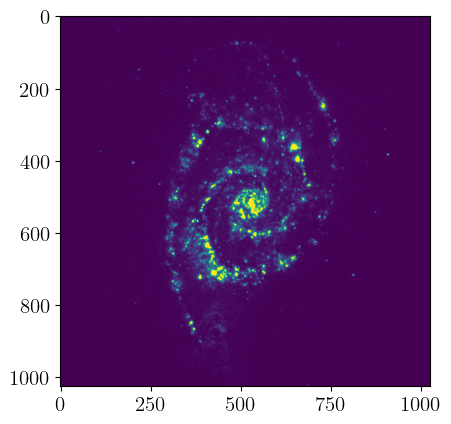

In [40]:
m51ha = fits.open('M51ha.fits')
datos_imagen = m51ha[0].data
m51ha.close()
plt.imshow(datos_imagen)
plt.show()

fft_m51ha = np.fft.fft2(datos_imagen)
ffts_m51ha = np.fft.fftshift(fft_m51ha)
ff = np.abs(np.log(ffts_m51ha))
pix = datos_imagen.shape[0]

In [39]:
datos_imagen.shape

(1024, 1024)

# Caso coordenadas no están en ENU

In [222]:
antenna_config_file = antenna_config_path + "\\vla.b.cfg"
data = np.loadtxt(antenna_config_file, dtype=dtype)

In [223]:
local_xyz = EarthLocation.from_geocentric(data["x"], data["y"], data["z"], u.m)

In [224]:
telescope_center = EarthLocation.of_site("vla")
latitude = telescope_center.to_geodetic().lat.to(u.rad).value

In [225]:
enu_coords = earth_location_to_local_enu(local_xyz, telescope_center)

[None, Text(0.5, 0, 'West-East / m'), Text(0, 0.5, 'South-North / m')]

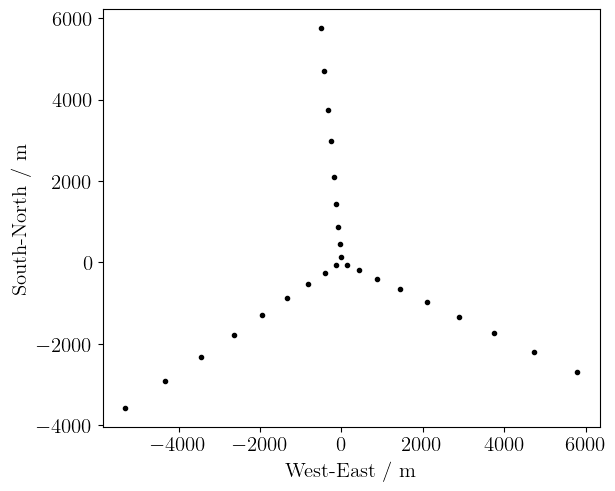

In [226]:
fig, ax = plt.subplots(layout='constrained')

ax.plot(enu_coords[0], enu_coords[1], '.k')
ax.set(
        aspect=1,
        xlabel='West-East / m',
        ylabel='South-North / m'
)

In [227]:
baseline_enu = baselines_enu(enu_coords)

In [228]:
baseline_equatorial = b_enu_to_b_equatorial(baseline_enu, latitude)

In [229]:
HA, dec = compute_HA(1.5, -45, 6)

In [234]:
cover = coverage(baseline_equatorial, HA, dec)/wavelength/1000

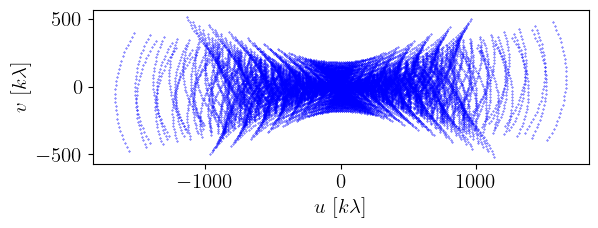

In [238]:
fig, ax = plt.subplots()
ax.scatter(cover[:,0],cover[:,1], c="blue", marker=".", s=0.4)
ax.set_xlabel(r'$u\ [k\lambda]$')
ax.set_ylabel(r'$v\ [k\lambda]$')
ax.set_aspect('equal')

# Caso las coordenadas ya están en ENU

In [18]:
antenna_config_file = antenna_config_path + "\\alma.cycle1.1.cfg"
dataENU = np.loadtxt(antenna_config_file, dtype=dtype)

In [19]:
enu_coords = np.vstack([dataENU["x"], dataENU["y"], dataENU["z"]])

[None, Text(0.5, 0, 'West-East / m'), Text(0, 0.5, 'South-North / m')]

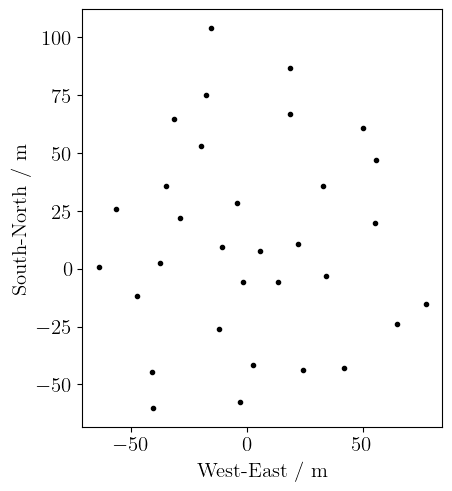

In [20]:
fig, ax = plt.subplots(layout='constrained')

ax.plot(enu_coords[0], enu_coords[1], '.k')
ax.set(
        aspect=1,
        xlabel='West-East / m',
        ylabel='South-North / m'
)

In [21]:
# Calculate combinations of pairs of antennas in ENU coordinates
antenna_ids = np.arange(0, enu_coords.shape[1])
n_antennas = len(antenna_ids)
b_enu = enu_coords[..., np.newaxis] - enu_coords[:, np.newaxis,:]
b_enu = b_enu[:, ~np.eye(b_enu.shape[-1],dtype=bool)]

In [22]:
abs_b = np.sqrt(np.sum(b_enu**2, axis=0))
azimuth, elevation = enu_to_local_altaz(b_enu, abs_b)

In [23]:
telescope_center = EarthLocation.of_site("alma")
latitude = telescope_center.to_geodetic().lat.to(u.rad).value

In [24]:
x_equatorial = (np.cos(latitude) * np.sin(elevation) - np.sin(latitude) * np.cos(elevation) * np.cos(azimuth))
y_equatorial = (np.cos(elevation) * np.sin(azimuth))
z_equatorial = (np.sin(latitude) * np.sin(elevation) + np.cos(latitude) * np.cos(elevation) * np.cos(azimuth))

In [25]:
xyz_equatorial = abs_b * np.vstack([x_equatorial, y_equatorial, z_equatorial])

In [52]:
#HA = np.arange(-0.5*15.*(np.pi/180.), 0.5*15.*(np.pi/180.), 0.1*(np.pi/180.))  # [radians]
HA = np.arange(-0.5, 0.5, 0.25) * np.pi / 12.
dec = np.radians(35)

In [56]:
R_matrix = calc_R(HA, dec)
uvw_meters = np.sum(R_matrix[...,np.newaxis]*xyz_equatorial[np.newaxis,:,np.newaxis,:], axis=1)/wavelength

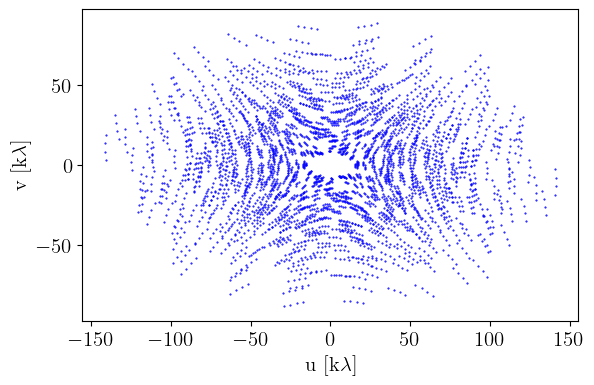

In [57]:
fig, ax = plt.subplots()
ax.scatter(uvw_meters[0]/1000,uvw_meters[1]/1000, c="blue", marker=".", s=1)
ax.set_xlabel(r'u [k$ \lambda$]') 
ax.set_ylabel(r'v [k$ \lambda$]')
ax.set_aspect('equal')

In [37]:
""" import matplotlib.animation
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()
fig, ax = plt.subplots()

#x = np.arange(0, len(HA))
def animate(t):
    plt.cla()
    plt.scatter(UV_coverage[0:t,0,:],UV_coverage[0:t,1,:], c="black", marker=".")

matplotlib.animation.FuncAnimation(fig, animate, frames=len(HA)) """


' import matplotlib.animation\nimport matplotlib.pyplot as plt\nimport numpy as np\nplt.rcParams["animation.html"] = "jshtml"\nplt.rcParams[\'figure.dpi\'] = 150  \nplt.ioff()\nfig, ax = plt.subplots()\n\n#x = np.arange(0, len(HA))\ndef animate(t):\n    plt.cla()\n    plt.scatter(UV_coverage[0:t,0,:],UV_coverage[0:t,1,:], c="black", marker=".")\n\nmatplotlib.animation.FuncAnimation(fig, animate, frames=len(HA)) '

In [33]:
HA, dec = compute_HA(0.5, 35, 6)

In [29]:
# Dado la rotación de la tierra, el objeto se "desplaza" en el cielo, por lo tanto se utiliza el
# ángulo horario y declinación para seguir su posición en el cielo

def calc_RR(H,dec):
    if np.isscalar(H):
        H = np.array([H])

    R = np.array([[np.sin(H), np.cos(H), np.zeros_like(H)],\
        [-np.sin(dec)*np.cos(H), np.sin(dec)*np.sin(H), np.cos(dec*np.ones_like(H))],\
        [np.cos(dec)*np.cos(H), -np.cos(dec)*np.sin(H), np.sin(dec*np.ones_like(H))]])

    return R

In [144]:
def grid_sampling(piximg, max_B, coverage):
    """ 
    piximg: cantidad de pixeles de la imagen modelo, tiene que ser nxn
    max_B: baseline mas largo
    uvcoverage: array uv cobertura

       """
    sampling = np.zeros((piximg, piximg)) + 1j*np.zeros((piximg, piximg))
    uvgrid = np.zeros((piximg, piximg)) + 1j*np.zeros((piximg, piximg))
    uvgrid2 = np.zeros((piximg, piximg)) + 1j*np.zeros((piximg, piximg))
    min_lambda=wavelength #minima longitud de onda lambda
    delta_x = (min_lambda / max_B) / 7
    delta_u = 1 / ((piximg * delta_x))

    u_pixel2 = np.floor(0.5 + coverage[:, 0] / delta_u + piximg / 2).astype(int)
    v_pixel2 = np.floor(0.5 + coverage[:, 1] / delta_u + piximg / 2).astype(int)

    """ for i in range(coverage.shape[0]):
      u_pixel = int(np.floor(0.5 + coverage[i,0]/delta_u) + piximg/2)
      v_pixel = int(np.floor(0.5 + coverage[i,1]/delta_u) + piximg/2)
      uvgrid2[v_pixel, u_pixel] += 1.0 + 1j*0.0 """
      
    np.add.at(uvgrid, (v_pixel2, u_pixel2), 1.0 + 1j*0.0)
    # S(u,v) = 1 otro caso S=0
    """ sampling = np.zeros_like(uvgrid)
    posiciones_con_valores = uvgrid != 0
    sampling[posiciones_con_valores] = 1 """
    sampling[v_pixel2, u_pixel2] = 1.0
    return sampling, uvgrid, uvgrid2


In [31]:
def coverage(baselines, HA, dec, wavelength):
    """
    baselines: arreglo de coordenadas de los baselines en el sistema ecuatorial
    """
    R_matrix = calc_RR(HA, dec)
    uvw_meters = np.sum(R_matrix[...,np.newaxis]*baselines[np.newaxis,:,np.newaxis,:], axis=1)
    UV_coverage = np.column_stack((uvw_meters[0].reshape(-1), uvw_meters[1].reshape(-1)))/wavelength
    return UV_coverage

In [62]:
cover = coverage(xyz_equatorial, HA, dec, wavelength)

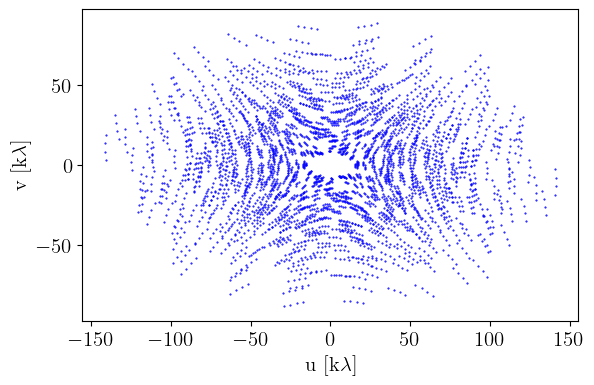

In [64]:
fig, ax = plt.subplots()
ax.scatter(cover[:,0]/1000,cover[:,1]/1000, c="blue", marker=".", s=1)
ax.set_xlabel(r'u [k$ \lambda$]') 
ax.set_ylabel(r'v [k$ \lambda$]')
ax.set_aspect('equal')

In [145]:
new_samplingEJ1, psf, psf3=grid_sampling(pix,np.max(np.abs(xyz_equatorial)), cover)

In [148]:
psf2 = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(psf)))
fft_norm = np.max(psf2.real)
psf2/= fft_norm

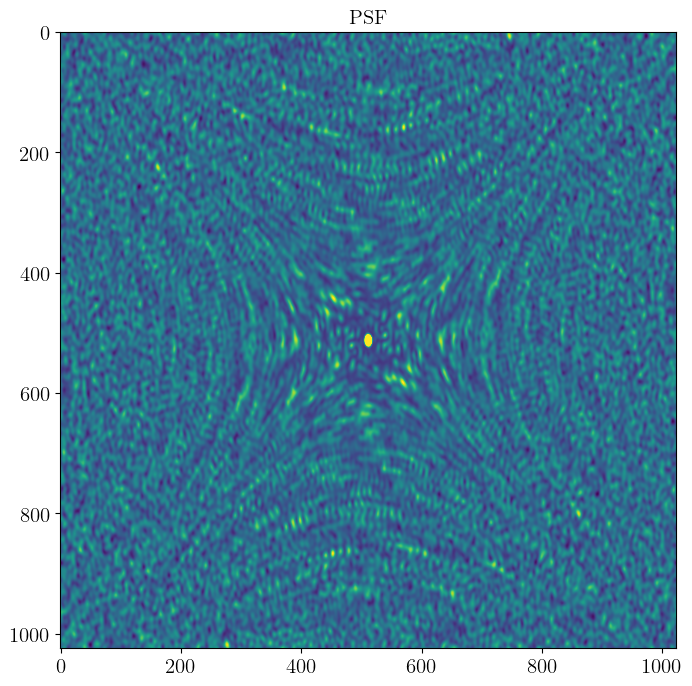

In [151]:
figure = plt.figure(figsize=(8, 8))
plt.subplot()
plt.title('PSF')
plt.imshow(psf2.real, vmax=0.1)

In [140]:
new_obs_EJ1 = np.abs(np.fft.ifft2(np.fft.ifftshift(ffts_m51ha*new_samplingEJ1)))

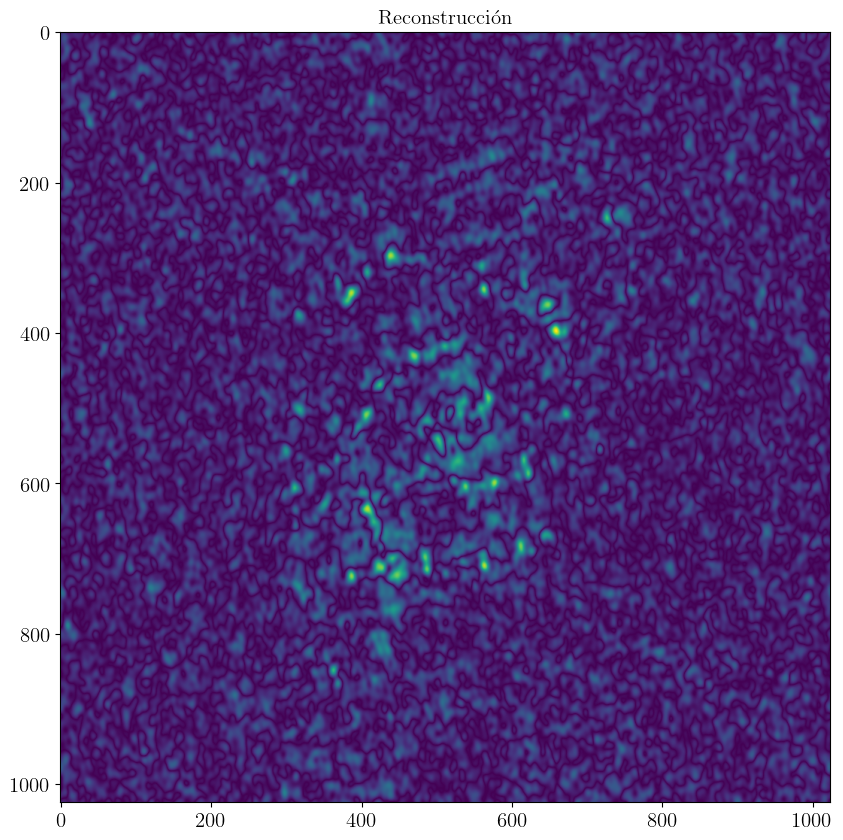

In [141]:
plt.figure(figsize=(10, 10))
plt.title('Reconstrucción')
plt.imshow(new_obs_EJ1.real)